In [2]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np       

import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta

from scipy.optimize import minimize


#Stats models and packages
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product

%matplotlib inline

In [3]:
df_forecast = pd.read_csv('Forecast.csv',parse_dates=['date'])

In [4]:
df_forecast.head()

,Unnamed: 0,date,store,item,Order Region,Order Country,Order State,Order City,Latitude,Longitude,Shipping Mode,Type,Late Delivery In Days,sales
0,0,2013-01-01,1,1,South Asia,India,Rajasthan,Bikaner,18.279451,-66.037064,Standard Class,TRANSFER,1,13
1,1,2013-01-02,1,1,South Asia,India,Rajasthan,Bikaner,37.292233,-121.881279,Standard Class,CASH,0,11
2,2,2013-01-03,1,1,South Asia,India,Maharashtra,Sangli,18.278439,-66.037056,First Class,DEBIT,1,14
3,3,2013-01-04,1,1,South Asia,India,Maharashtra,Sangli,42.526276,-70.927032,First Class,TRANSFER,1,13
4,4,2013-01-05,1,1,South Asia,India,Maharashtra,Sangli,18.284050,-66.037056,First Class,DEBIT,1,10


In [5]:
df_forecast.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

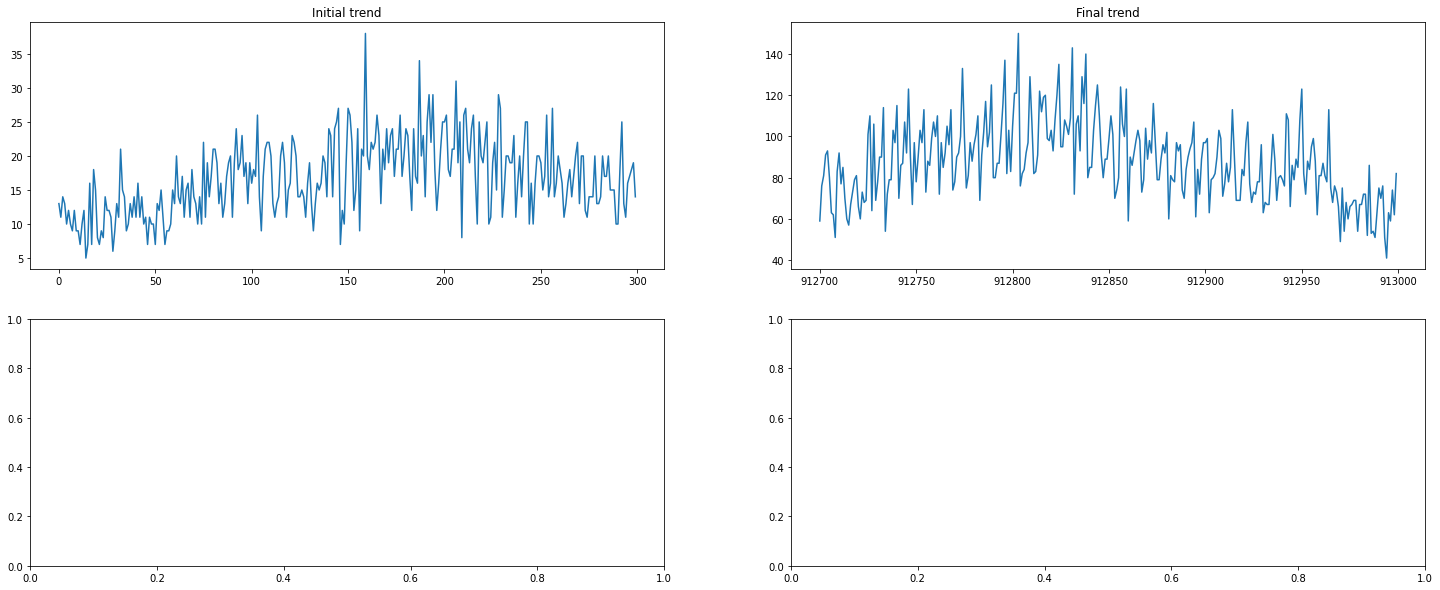

In [6]:
fig,a = plt.subplots(2,2)
fig.set_size_inches(25,10)
a[0][0].set_title('Initial trend')
a[0][0].plot(df_forecast.sales[:300])
a[0][1].set_title('Final trend')
a[0][1].plot(df_forecast.sales[-300:])
#a[1][0].set_size_inches(25,5)



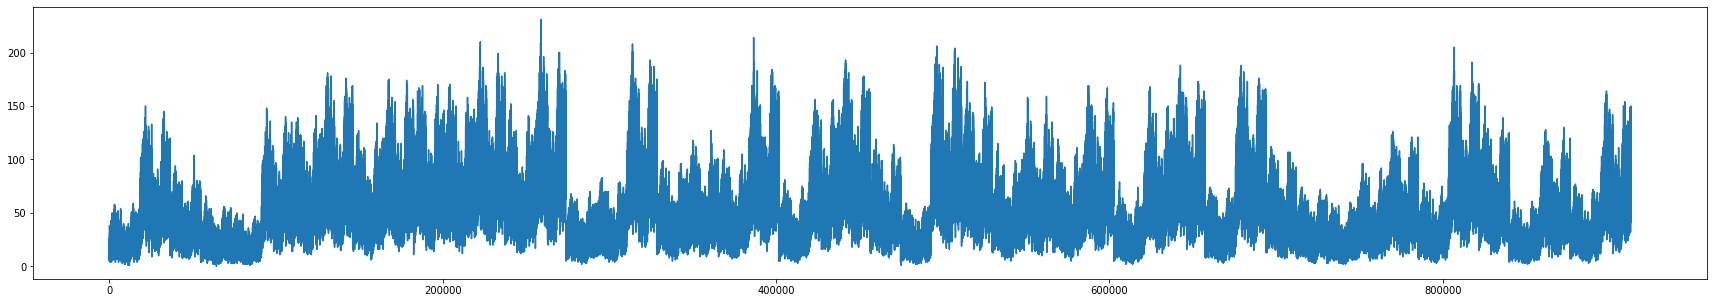

In [7]:

fig , a = plt.subplots(1)
fig.set_size_inches(30,5)
a.plot(df_forecast.sales[:])

In [8]:
#Metrics calculation

In [9]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [10]:
def mean_absolute_percentage_error(y_true,  ypred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [11]:
def moving_average(series, n):
    #calculate average of last n observations
    return np.average(series[-n:])

moving_average(df_forecast.sales,30)

64.03333333333333

In [12]:
df_forecast.head()

,date,store,item,Order Region,Order Country,Order State,Order City,Latitude,Longitude,Shipping Mode,Type,Late Delivery In Days,sales
0,2013-01-01,1,1,South Asia,India,Rajasthan,Bikaner,18.279451,-66.037064,Standard Class,TRANSFER,1,13
1,2013-01-02,1,1,South Asia,India,Rajasthan,Bikaner,37.292233,-121.881279,Standard Class,CASH,0,11
2,2013-01-03,1,1,South Asia,India,Maharashtra,Sangli,18.278439,-66.037056,First Class,DEBIT,1,14
3,2013-01-04,1,1,South Asia,India,Maharashtra,Sangli,42.526276,-70.927032,First Class,TRANSFER,1,13
4,2013-01-05,1,1,South Asia,India,Maharashtra,Sangli,18.284050,-66.037056,First Class,DEBIT,1,10


In [13]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)        

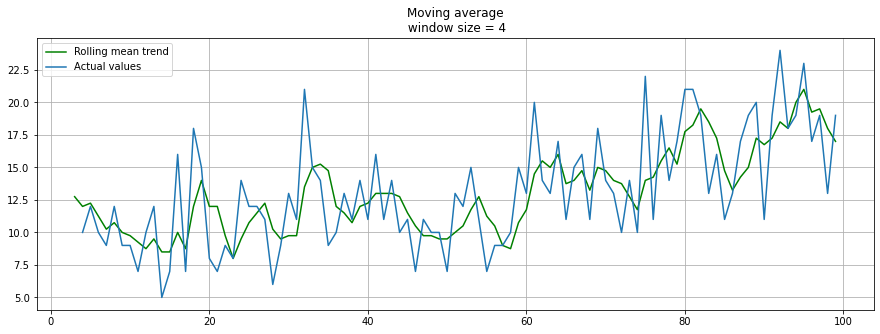

In [14]:
plotMovingAverage(df_forecast[['sales']][:100],4)

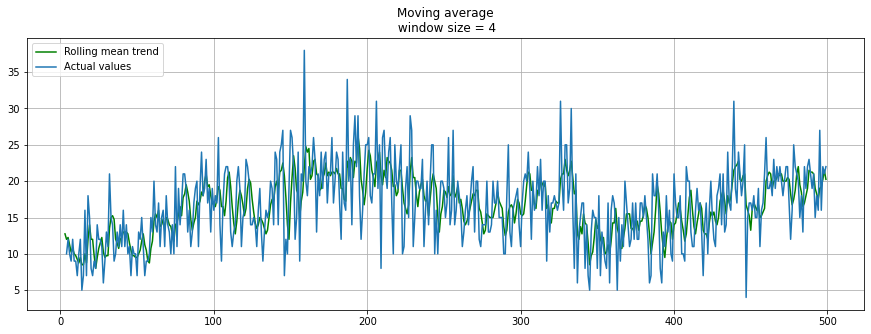

In [15]:
plotMovingAverage(df_forecast[['sales']][:500],4)

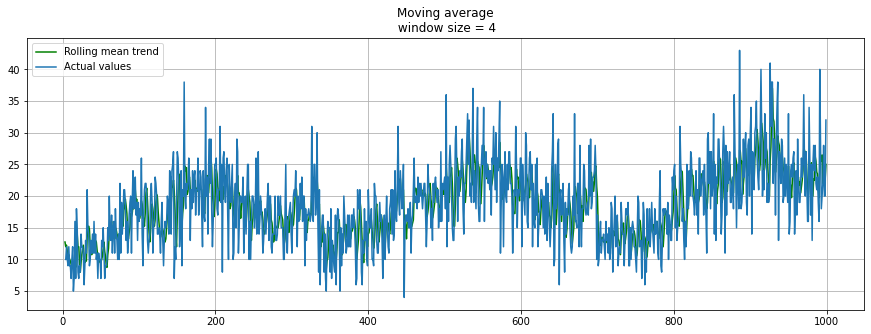

In [16]:
plotMovingAverage(df_forecast[['sales']][:1000],4)

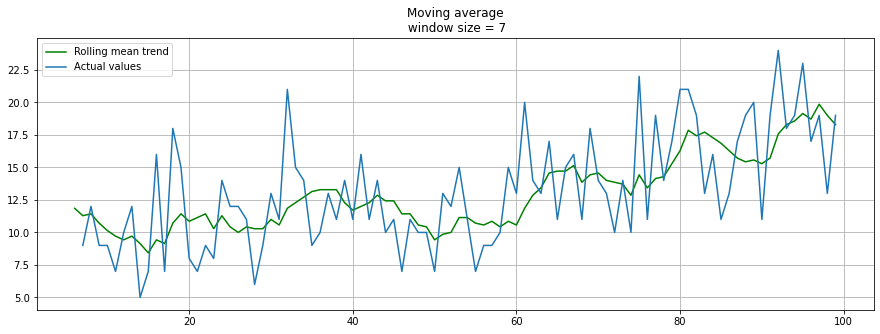

In [17]:
plotMovingAverage(df_forecast[['sales']][:100],7)

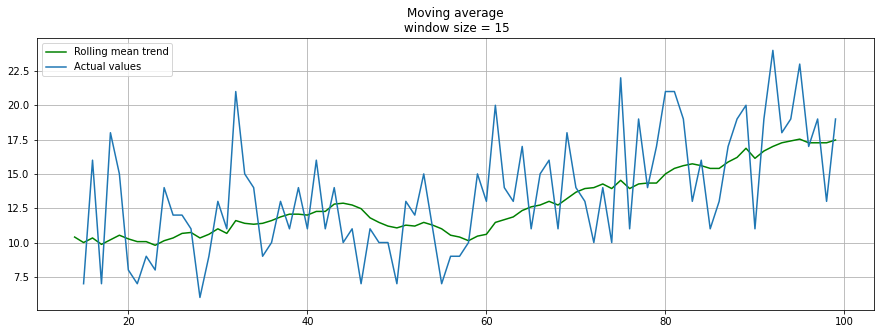

In [18]:
plotMovingAverage(df_forecast[['sales']][:100],15)

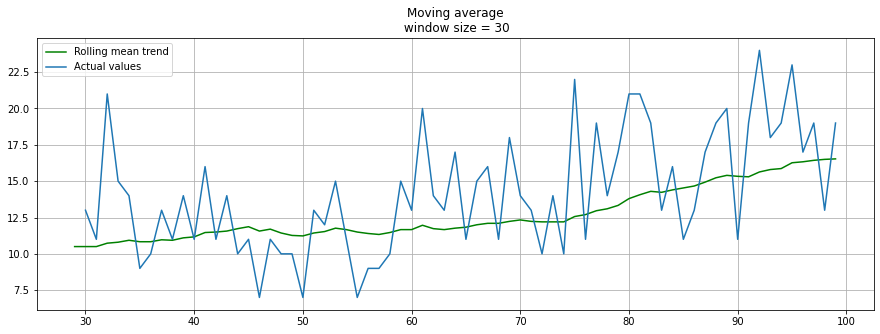

In [19]:
plotMovingAverage(df_forecast[['sales']][:100],30)

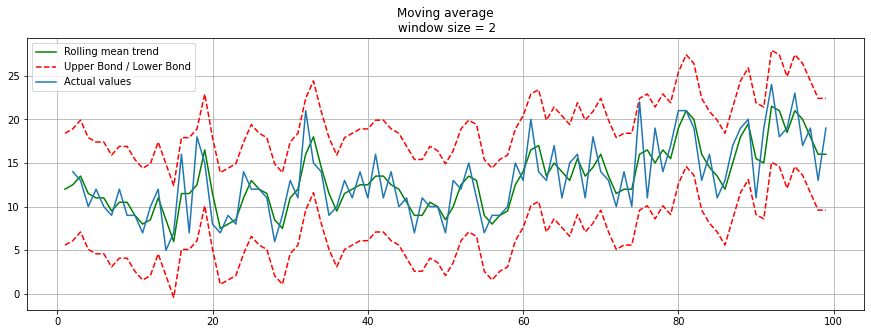

In [20]:
plotMovingAverage(df_forecast[['sales']][:100],2, plot_intervals=True)

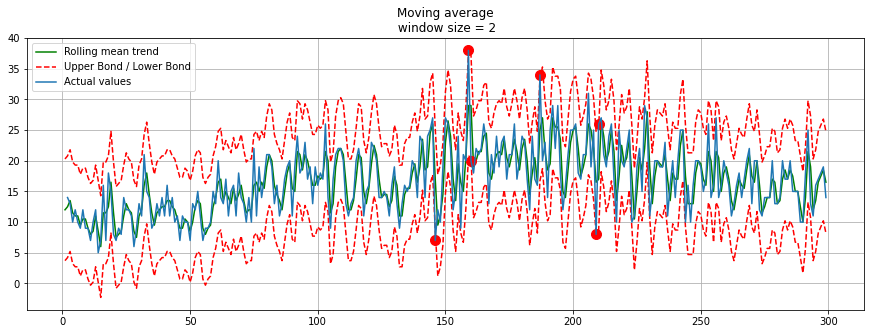

In [21]:
plotMovingAverage(df_forecast[['sales']][:300],2, plot_intervals=True, plot_anomalies=True)

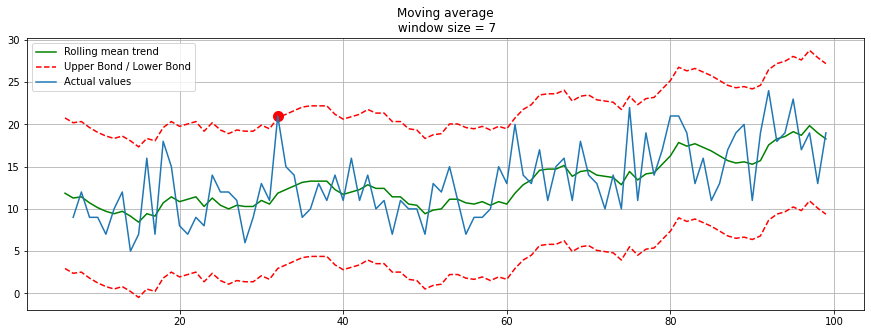

In [22]:
plotMovingAverage(df_forecast[['sales']][:100],7, plot_intervals=True, plot_anomalies=True)

In [23]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [24]:
weighted_average(df_forecast.sales,[0.6, 0.3, 0.1])

71.19999999999999

In [25]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1,len(series)):
        result.append(alpha * series[n] + (1-alpha) * result[n-1])
    return result

In [26]:
def plotExponentialSmoothing(series, alphas):
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

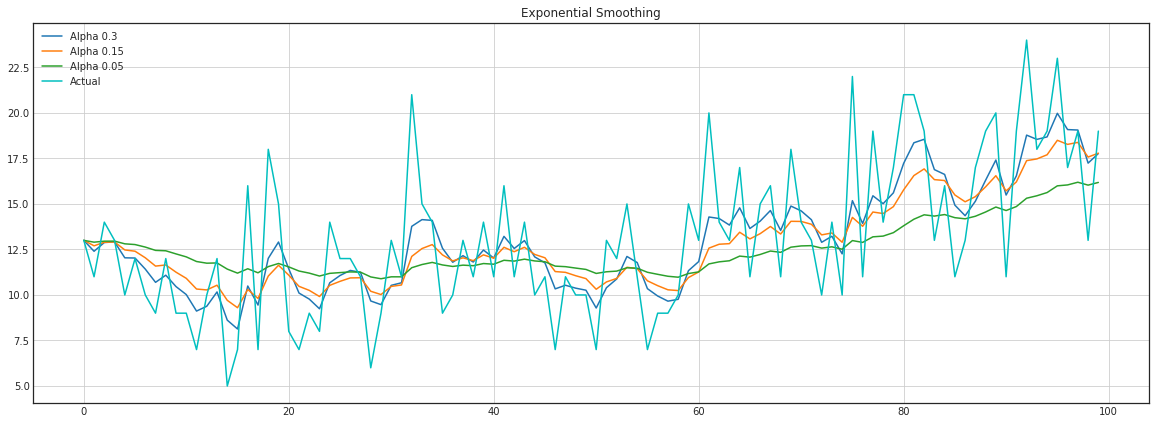

In [27]:
plotExponentialSmoothing(df_forecast.sales[:100], [0.3, 0.15, 0.05])

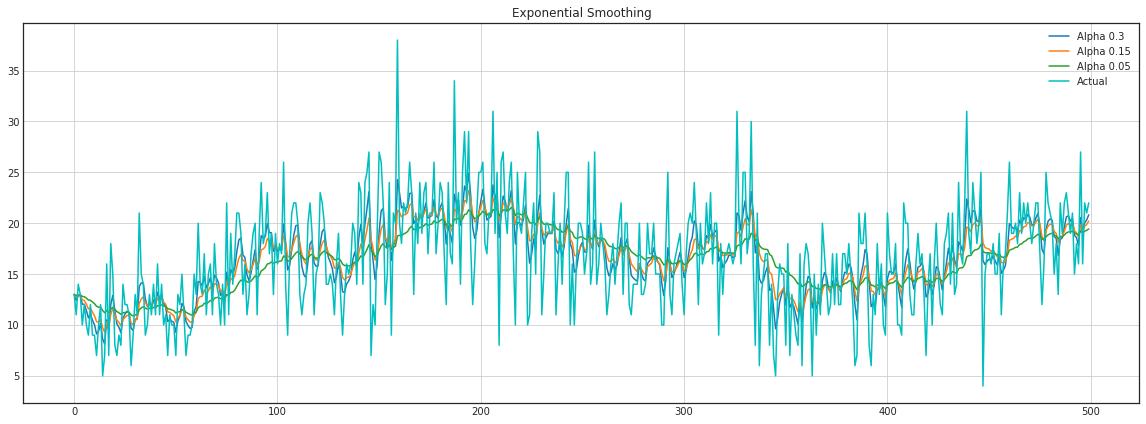

In [28]:
plotExponentialSmoothing(df_forecast.sales[:500], [0.3, 0.15, 0.05])

In [29]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1,len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [30]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20,8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha,beta))
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title('Double exponential smooting')
        plt.grid(True)
        

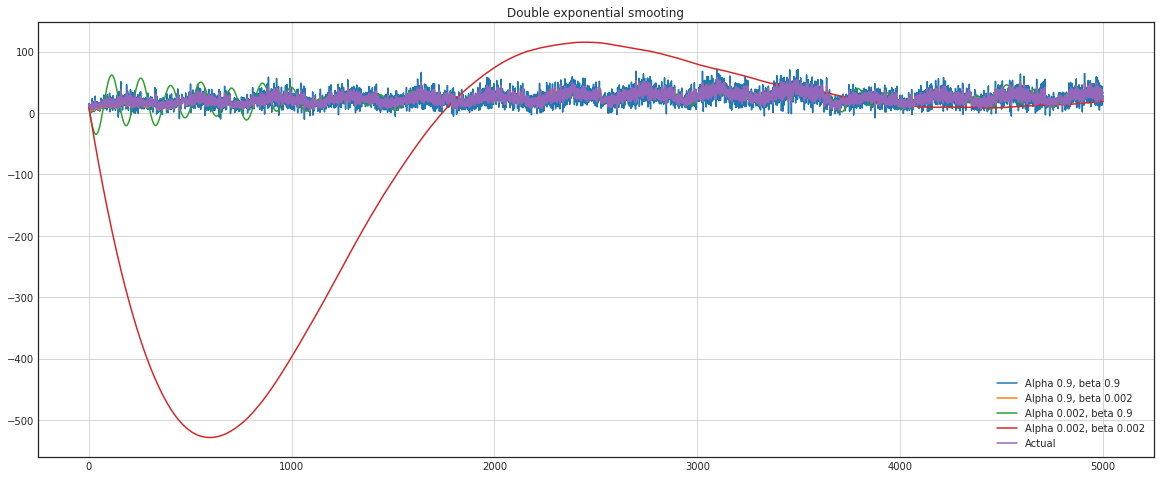

In [31]:
plotDoubleExponentialSmoothing(df_forecast.sales[:5000], alphas=[0.9,0.002], betas=[0.9,0.002])

In [32]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [33]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error,slen = 30):
    errors = []
    values = series.values
    alpha , beta, gamma = params
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    for train,test in tscv.split(values):
        model = HoltWinters(series = values[train], slen = slen,
                           alpha = alpha,
                           beta = beta,
                           gamma = gamma,
                           n_preds = len(test))
        model.triple_exponential_smoothing()
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [ ]:
test_length = df_forecast.shape[0]*0.20
print('test length {}'.format(test_length))

data = df_forecast.sales[:int(-test_length)]

x = [0,0,0]

#minimizing the loss function
opt = minimize(timeseriesCVscore, x0 = x, args = (data, mean_squared_log_error), method="TNC", 
              bounds = ((0,1),(0,1),(0,1)))
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = 30, alpha = alpha_final,
                   beta = beta_final,
                   gamma = gamma_final,
                   n_preds = 120)
model.triple_exponential_smoothing()


test length 182600.0


In [ ]:


def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);



In [ ]:
plotHoltWinters(df_forecast.sales[182400:182700])

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");


In [ ]:
def plotProcess(n_samples = 1000, rho = 0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)